# Chuẩn bị dữ liệu

## Tải dataset từ kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/HK2 2023 - 2024/Học sâu/Giữa kỳ/midterm_Q2/data')

In [ ]:
!pip install kaggle
# gỡ bỏ thư mục kaggle cũ nếu còn
!rm /.kaggle/*
!rmdir /.kaggle
# tạo thư mục kaggle và đưa file token vào
!mkdir /.kaggle
!cp kaggle.json /.kaggle
!cp -r /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/.kaggle/*': No such file or directory
rmdir: failed to remove '/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_

## Load dataset

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd

root_dir = '.'

In [ ]:
caption_df = pd.read_csv(root_dir + '/captions.txt')
caption_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


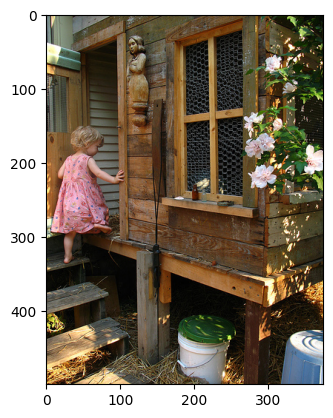

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [ ]:
idx = 0
img = Image.open(root_dir + '/Images/' + caption_df['image'][idx]).convert('RGB')

plt.imshow(img)
plt.show()
for i in range(5):
  print(caption_df['caption'][idx + i])

## Tạo custom dataset để lấy hình ảnh và caption



In [ ]:
import torch
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from transformers import AutoTokenizer

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None, tokenizer=None, max_length=20):
        self.root_dir = root_dir
        self.df = pd.read_csv(ann_file)
        self.transform = transform
        if tokenizer is None:
            self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        else:
            self.tokenizer = tokenizer
        self.max_length = max_length
        self.images = self.df['image']
        self.captions = self.df['caption']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_location = self.root_dir + '/Images/' + self.images[index]
        image = Image.open(img_location).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        caption = self.tokenizer.encode(self.captions[index],
                                      padding='max_length',
                                      truncation=True,
                                      return_tensors='pt',
                                      max_length=self.max_length)
        return image, caption.squeeze(0)

    def get_original_item(self, index):
        start_idx = index - index%5
        end_idx = start_idx + 5
        # image
        img_location = self.root_dir + '/Images/' + self.images[index]
        image = Image.open(img_location).convert('RGB')
        # captions
        list_captions = [self.captions[i] for i in range(start_idx, end_idx)]
        return image, list_captions

In [ ]:
# Tạo transformations để chuyển đổi hình ảnh
image_transform = transforms.Compose([
    # Resize hình ảnh
    transforms.Resize((256, 256)),
    # Cắt hình ảnh với vùng ngẫu nhiên
    transforms.RandomCrop(224),
    # Chuyển đổi thành Tensor cho việc huấn luyện với Pytorch
    transforms.ToTensor(),
    # Chuẩn hoá hình ảnh
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
print("===Information about tokens===")
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.vocab_size)
print("===Examples===")
sentence = 'I am a student'
encoded = tokenizer.encode(sentence,
                            padding='max_length',
                            truncation=True,
                            return_tensors='pt',
                            max_length=20)
decoded_text = tokenizer.decode(encoded.squeeze(0))
decoded_arr = tokenizer.convert_ids_to_tokens(encoded.squeeze(0))
print(encoded)
print(decoded_text)
print(decoded_arr)

===Information about tokens===
[CLS] 101
[SEP] 102
[PAD] 0
30522
===Examples===
tensor([[ 101, 1045, 2572, 1037, 3076,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
[CLS] i am a student [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
['[CLS]', 'i', 'am', 'a', 'student', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
dataset = CustomDataset('./', 'captions.txt', image_transform, tokenizer)
# Tách dataset thành train, val, test
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

40455
(tensor([[[-0.9534, -0.8849, -0.6623,  ..., -1.0562, -1.1418, -1.0733],
         [-0.8678, -0.9363, -0.6452,  ..., -0.9363, -0.9705, -1.0733],
         [-0.7822, -0.9534, -0.6109,  ..., -0.8335, -0.9363, -1.0390],
         ...,
         [-0.0116,  0.1254,  0.3481,  ..., -0.6452, -0.7308, -0.6965],
         [-0.0458,  0.0227,  0.0741,  ..., -0.5253, -0.7479, -0.7993],
         [-0.1999, -0.0458,  0.1597,  ..., -0.4568, -0.6452, -0.7479]],

        [[-0.5476, -0.7752, -0.4076,  ..., -1.1078, -1.1604, -1.1078],
         [-0.4776, -0.8102, -0.3901,  ..., -1.0028, -1.0728, -1.0728],
         [-0.3200, -0.8452, -0.4076,  ..., -0.9153, -0.9503, -0.9853],
         ...,
         [-0.2850, -0.1975,  0.0126,  ..., -0.0049, -0.1625, -0.1099],
         [-0.3725, -0.3550, -0.3550,  ..., -0.0224, -0.1450, -0.1275],
         [-0.5476, -0.3901, -0.1275,  ..., -0.0224, -0.1099, -0.0749]],

        [[-0.5844, -0.6018, -0.3578,  ..., -1.4907, -1.4907, -1.3861],
         [-0.4624, -0.6193, -0.3230,  

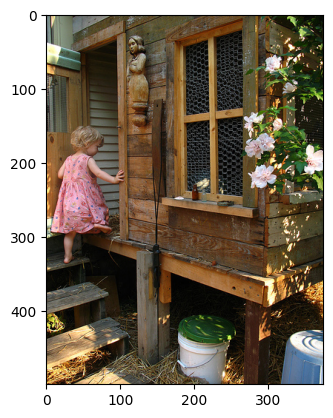

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [ ]:
print(len(dataset))
print(dataset[2])
print(train_data[0])
# Plot item
print('===Plot original item===')
img, caps = dataset.get_original_item(3)
plt.imshow(img)
plt.show()
print(caps)

## Tạo Data Loader

In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
batch_size = 32

train_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
for batch in train_loader:
  images, captions = batch
  print(images)
  print(captions)
  break

tensor([[[[ 0.6049, -0.0629, -0.9705,  ..., -1.7754, -1.8439, -1.8268],
          [-0.5424, -0.9192, -0.9534,  ..., -1.9124, -1.4843, -1.5014],
          [-0.8164, -0.7822, -0.9877,  ..., -1.9467, -1.8610, -1.8953],
          ...,
          [ 0.1939, -0.3883,  0.7591,  ...,  1.1529,  1.4269,  1.7352],
          [ 0.5707,  1.6838,  1.7180,  ...,  1.2899,  1.3927,  1.6153],
          [ 1.9920,  1.5468,  0.8789,  ...,  1.4440,  2.0263,  1.7865]],

         [[ 1.0805,  0.6429,  0.0476,  ..., -1.5630, -1.5630, -1.4930],
          [ 0.1527, -0.0224,  0.0651,  ..., -1.5980, -1.0553, -0.9853],
          [ 0.0826,  0.1527, -0.0749,  ..., -1.7731, -1.6506, -1.6331],
          ...,
          [-0.1275, -0.4601,  0.6604,  ...,  0.9230,  1.2381,  1.5882],
          [ 0.4678,  1.8158,  1.7283,  ...,  0.9930,  1.2556,  1.5182],
          [ 2.0959,  1.5882,  0.7479,  ...,  1.3081,  2.0434,  1.7983]],

         [[ 0.7402,  0.1476, -0.5321,  ..., -1.4210, -1.4210, -1.3513],
          [-0.2184, -0.4450, -

# Xây dựng mô hình

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from torch import nn, optim
from torchvision import models
from torchvision.models.resnet import ResNet50_Weights
from matplotlib import pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

## Xây dựng cấu trúc các mô hình và tạo các hàm hỗ trợ

In [52]:
# CNN
class CNN(nn.Module):
    def __init__(self, embed_size, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.cnn = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        # Đóng băng các tầng của resnet50
        for param in self.cnn.parameters():
            param.requires_grad = False
        # thay thế tầng fc của resnet50 với kích thước embed_size
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, embed_size)
        self.relu = nn.ReLU()

    def forward(self, images):
        features = self.cnn(images)
        features = self.relu(features)
        return features

# LSTM với attention
class LSTMWithoutAttention(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(LSTMWithoutAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])
        embeddings = torch.cat((features.unsqueeze(dim=1), embeddings), dim=1)
        outputs, _ = self.lstm(embeddings)
        outputs = self.fc(outputs)
        return outputs

# Model không có attention
class ModelWithoutAttention(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ModelWithoutAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder = CNN(embed_size)
        self.decoder = LSTMWithoutAttention(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, tokenizer, max_length=50):
        result = []
        with torch.no_grad():
            features = self.encoder(image)
            input = features.unsqueeze(1)
            # num_layers, batch_size=1, hidden_size
            states = (torch.randn(self.num_layers, 1, self.hidden_size).to(image.device),
                      torch.randn(self.num_layers, 1, self.hidden_size).to(image.device))

            for _ in range(max_length):
                out, states = self.decoder.lstm(input, states)
                # 1, batch_size=1, vocab_size
                out = self.decoder.fc(out)
                # 1, vocab_size
                out = out.squeeze(1)
                # softmax
                predicted = out.argmax(1)
                result.append(predicted.cpu().numpy()[0])
                input = self.decoder.embed(predicted.unsqueeze(0))
                if predicted.item() == tokenizer.sep_token_id:
                  break

        return tokenizer.decode(result, skip_special_tokens=True)

In [ ]:
# Tạo các hàm hỗ trợ
def plot(train_losses, validation_losses, title='Losses epochs'):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Train losses')
    plt.plot(epochs, validation_losses, label='Validation losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

def validation(model, criterion, val_loader):
    total_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        model.eval()
        for images, captions in val_loader:
            # Đưa dữ liệu vào device
            images = images.to(device)
            captions = captions.to(device)
            # Tính toán outputs và tính loss
            outputs = model(images, captions)
            loss = criterion(outputs.reshape(-1, vocab_size), captions.reshape(-1))
            total_loss += loss.item()
            num_batches += 1
    average_loss = total_loss / num_batches
    return average_loss

def train(model, train_loader, val_loader, criterion, optimizer,
          device='cpu', num_epochs=5, num_iters_no_change=3):
    train_losses, validation_losses = [], []
    best_val_loss = 99999
    best_model = None
    counter = 0

    for epoch in range(num_epochs):
        model.train()

        # Train model và tính train loss
        for images, captions in train_loader:
            '''
            Shape of elements:
            - Inputs:
              + images: [batch_size, 3, transformed_size]
              + captions: [batch_size, seq_length(max_length of tokenizer)]
              => captions: [batch_size, seq_length - 1]
            - Outputs:
              + outputs: [batch_size, seq_length, vocab_size]
              => outputs: [batch_size*seq_length, vocab_size]
              + targets: [batch_size*seq_length]
            '''
            # Đưa dữ liệu vào device
            images = images.to(device)
            captions = captions.to(device)
            # Forward
            outputs = model(images, captions)
            # Tính toán loss
            outputs = outputs.reshape(-1, vocab_size)
            targets = captions.reshape(-1)
            loss = criterion(outputs, targets)
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Lưu thông tin train loss
        train_loss = loss.item()
        train_losses.append(train_loss)

        # Tính toán và lưu thông tin val loss
        val_loss = validation(model, criterion, val_loader)
        validation_losses.append(val_loss)

        # Kiểm tra early stopping và lưu lại model tốt nhất
        if val_loss < best_val_loss:
            counter = 0
            best_val_loss = val_loss
            best_model = model
        else:
            counter += 1
            if counter >= num_iters_no_change:
                print(f'Early stopping at epoch {epoch+1}')
                break

        # In thông tin loss tại mỗi epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss}, Validation loss: {val_loss}')

    return best_model, best_val_loss, train_losses, validation_losses

def inference(model, test_data, num_samples=3, n_grams=4, device='cuda'):
    with torch.no_grad():
        model.eval()
        for i in range(num_samples):
            img, caps = test_data.dataset.get_original_item(test_data.indices[i])

            # Xử lý data để dự đoán
            transformed_img = image_transform(img).unsqueeze(0)
            transformed_img = transformed_img.to(device)
            captions_tokenized = [word_tokenize(cap) for cap in caps]

            # Dự đoán và lấy kết quả
            result = model.caption_image(transformed_img, tokenizer)
            result_tokenized = word_tokenize(result)

            # Tính BLEU score
            smoothing = SmoothingFunction()
            weights = tuple([0.25 for _ in range(n_grams)])
            BLEU_score = sentence_bleu(
                references=captions_tokenized,
                hypothesis=result_tokenized,
                weights=weights,
                smoothing_function=smoothing.method1
            )

            # In kết quả
            plt.figure()
            plt.imshow(img)
            plt.show()
            print('Expected captions:')
            for cap in caps:
                print('-', cap)
            print('Predicted caption:', result)
            print('BLEU score:', BLEU_score)
            print()

## Train và lưu các mô hình

In [ ]:
# Khởi tạo các hyper parameters
embed_size = 256      # kích thước vector
hidden_size = 512
vocab_size = tokenizer.vocab_size
num_layers = 1
learning_rate = 0.001
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = 'cuda'

In [ ]:
device

'cpu'

### Model không có attention

In [ ]:
# Khởi tạo mô hình, loss function và optimizer
model = ModelWithoutAttention(
    embed_size=embed_size,
    hidden_size=hidden_size,
    vocab_size = vocab_size,
    num_layers=num_layers
).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.7MB/s]


In [ ]:
model

ModelWithoutAttention(
  (encoder): CNN(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(in

Epoch [1/5], Train loss: 2.7758662700653076, Validation loss: 3.034649392751258
Epoch [2/5], Train loss: 3.1613101959228516, Validation loss: 2.7858661647856704
Epoch [3/5], Train loss: 2.668548345565796, Validation loss: 2.6646873932185136
Epoch [4/5], Train loss: 2.387251853942871, Validation loss: 2.616614383036696
Epoch [5/5], Train loss: 2.1861374378204346, Validation loss: 2.6076427914026215


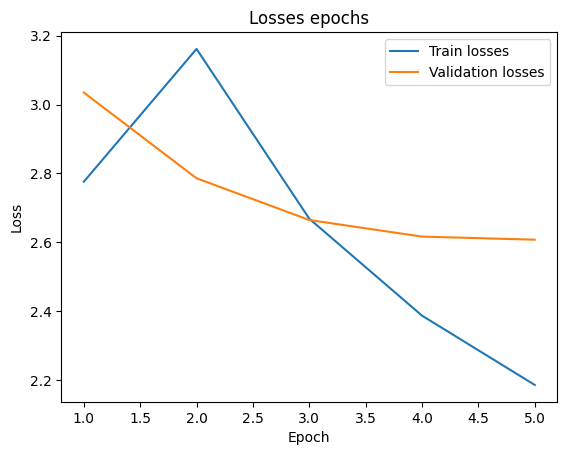

In [ ]:
num_epochs = 5
# train và mô hình without attention
best_model, best_val_loss, train_losses, validation_losses = \
train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs)
plot(train_losses, validation_losses)
torch.save(best_model, 'model-without-attention.pth')

### Model với attention

# Sử dụng các mô hình để dự đoán

In [ ]:
# Mô hình không có attention
model_without_attention = ModelWithoutAttention(
    embed_size=embed_size,
    hidden_size=hidden_size,
    vocab_size = vocab_size,
    num_layers=num_layers
).to(device)
model_without_attention.load_state_dict(torch.load('model-without-attention.pth', map_location=device).state_dict())
inference(model_without_attention, test_data, num_samples=5, device=device)

Output hidden; open in https://colab.research.google.com to view.